In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.keras.applications import DenseNet121
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,MaxPooling2D , Conv2D,Flatten
from tensorflow.keras.models import Sequential

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report


from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_dir = "../input/ucf-crime-dataset/Train"
test_dir = "../input/ucf-crime-dataset/Test"

SEED = 12
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 32
EPOCHS = 5
LR =  0.001

In [3]:
crime_types=os.listdir(train_dir)
n=len(crime_types)
print("Number of crime categories : ",n)

Number of crime categories :  14


In [4]:
crime_types

['RoadAccidents',
 'Assault',
 'Vandalism',
 'Arrest',
 'Shooting',
 'NormalVideos',
 'Arson',
 'Explosion',
 'Shoplifting',
 'Robbery',
 'Stealing',
 'Burglary',
 'Abuse',
 'Fighting']

Crimes have been catogarized in 14 different types.

In [5]:
crimes={}
train=test=0
for clss in crime_types:
    num=len(os.listdir(os.path.join(train_dir,clss)))
    train+=num
    test+=len(os.listdir(os.path.join(test_dir,clss)))
    
    crimes[clss]=num

In [6]:
crimes

{'RoadAccidents': 23486,
 'Assault': 10360,
 'Vandalism': 13626,
 'Arrest': 26397,
 'Shooting': 7140,
 'NormalVideos': 947768,
 'Arson': 24421,
 'Explosion': 18753,
 'Shoplifting': 24835,
 'Robbery': 41493,
 'Stealing': 44802,
 'Burglary': 39504,
 'Abuse': 19076,
 'Fighting': 24684}

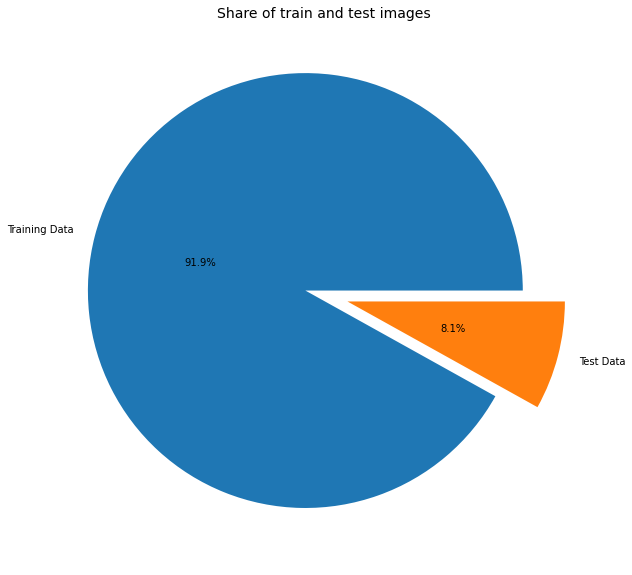

In [7]:
plt.figure(figsize=(15, 10))
plt.pie(x=np.array([train,test]), autopct="%.1f%%", explode=[0.1, 0.1], labels=["Training Data", "Test Data"], pctdistance=0.5)
plt.title("Share of train and test images ", fontsize=14);

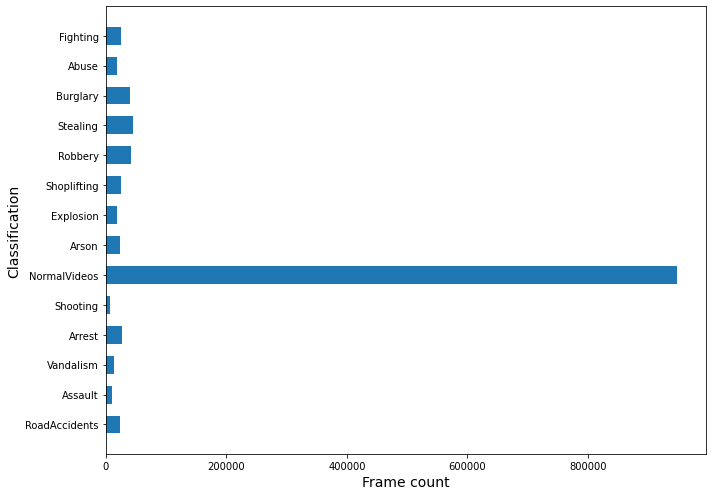

In [8]:
plt.figure(figsize=(10, 7))
plt.barh(list(crimes.keys()), list(crimes.values()), height=0.6, align="center")
plt.yticks(rotation=0)

plt.xlabel("Frame count", fontsize=14)
plt.ylabel("Classification", fontsize=14)
plt.tight_layout()
plt.show()


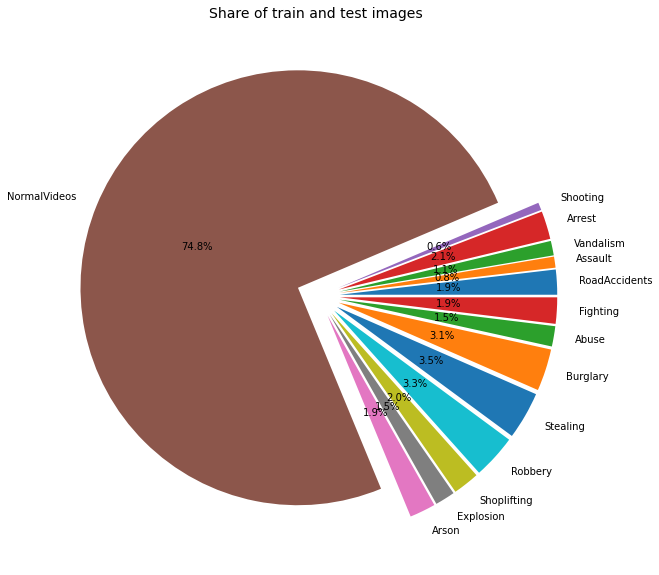

In [9]:
plt.figure(figsize=(15,10))
plt.pie(x=np.array(list(crimes.values())), autopct="%.1f%%", explode=[0.1]*n,labels=list(crimes.keys()), pctdistance=0.5)
plt.title("Share of train and test images ", fontsize=14);

In [10]:
IMG_WIDTH=64
IMG_HEIGHT=64

IMG_SHAPE=(IMG_HEIGHT,IMG_WIDTH)
seed=69

INPUT_SHAPE=(IMG_HEIGHT,IMG_WIDTH,3)

In [11]:
train_set=image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SHAPE,
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset="training",
)

val_set=image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SHAPE,
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset="validation",
)

test_set=image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    class_names=None,
    batch_size=BATCH_SIZE,
    image_size=IMG_SHAPE,
    shuffle=False,
    seed=seed,
)

Found 1266345 files belonging to 14 classes.
Using 1013076 files for training.



User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

Found 1266345 files belonging to 14 classes.
Using 253269 files for validation.
Found 111308 files belonging to 14 classes.


In [12]:
from tensorflow.keras.applications import MobileNetV2

def create_mobilenetv2_model():
    base_model = MobileNetV2(include_top=False, input_shape=INPUT_SHAPE, weights='/kaggle/input/mobilenet/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5')
    
    for layer in base_model.layers:
        layer.trainable = False
    
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(n, activation='softmax', name='classification'))
    
    model.summary()
    
    return model


In [13]:
model=create_mobilenetv2_model()

model.compile(optimizer="adam", 
                loss='categorical_crossentropy',
                metrics = [tf.keras.metrics.AUC()])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_64 (Functio (None, 2, 2, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
classification (Dense)       (None, 14)                1806      
Total params: 2,423,758
Trainable params: 165,774
Non-trainable params: 2,257,984
_________________________________________________________________


In [14]:
history = model.fit(x = train_set,validation_data=val_set,epochs = EPOCHS)

Epoch 1/5
31659/31659 [==============================] - 3239s 102ms/step - loss: 0.3850 - auc: 0.9903 - val_loss: 0.2194 - val_auc: 0.9956
Epoch 2/5
31659/31659 [==============================] - 2980s 94ms/step - loss: 0.2543 - auc: 0.9946 - val_loss: 0.1784 - val_auc: 0.9968
Epoch 3/5
31659/31659 [==============================] - 3148s 99ms/step - loss: 0.2218 - auc: 0.9955 - val_loss: 0.1628 - val_auc: 0.9971
Epoch 4/5
31659/31659 [==============================] - 3060s 97ms/step - loss: 0.2023 - auc: 0.9961 - val_loss: 0.1516 - val_auc: 0.9972
Epoch 5/5
31659/31659 [==============================] - 3071s 97ms/step - loss: 0.1910 - auc: 0.9963 - val_loss: 0.1483 - val_auc: 0.9972


In [15]:
y_true =  np.array([])

for x, y in test_set:
  y_true = np.concatenate([y_true, np.argmax(y.numpy(), axis=-1)])

In [16]:
y_pred=model.predict(test_set)

In [17]:
from sklearn.metrics import classification_report

# Convert y_pred to labels
y_pred_labels = np.argmax(y_pred, axis=-1)

# Generate classification report
report = classification_report(y_true, y_pred_labels)

print(report)


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       297
         1.0       0.06      0.07      0.06      3365
         2.0       0.14      0.05      0.07      2793
         3.0       0.01      0.00      0.00      2657
         4.0       0.21      0.05      0.08      7657
         5.0       0.22      0.02      0.04      6510
         6.0       0.02      0.02      0.02      1231
         7.0       0.64      0.83      0.72     64952
         8.0       0.11      0.13      0.12      2663
         9.0       0.00      0.02      0.01       835
        10.0       0.03      0.00      0.00      7630
        11.0       0.08      0.05      0.06      7623
        12.0       0.06      0.13      0.08      1984
        13.0       0.00      0.00      0.00      1111

    accuracy                           0.50    111308
   macro avg       0.11      0.10      0.09    111308
weighted avg       0.42      0.50      0.44    111308



In [18]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(crime_types):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

ROC AUC score: 0.7935415660137267


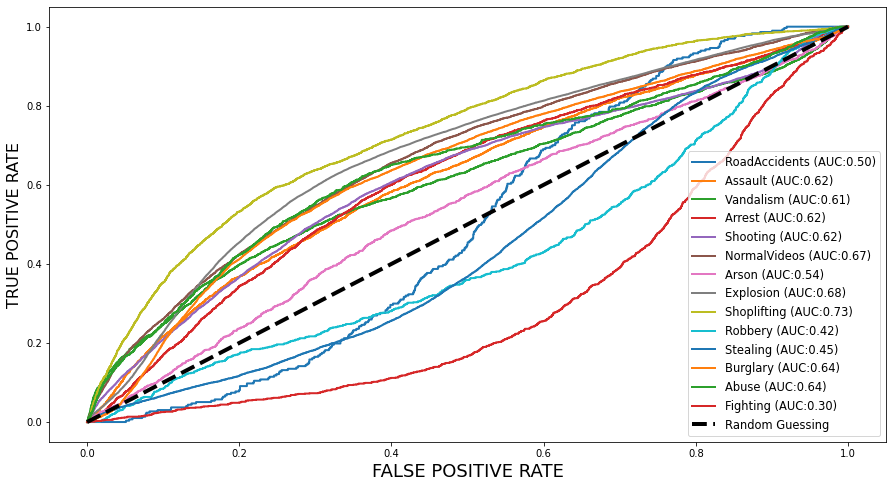

In [19]:
fig, c_ax = plt.subplots(1,1, figsize = (15,8))


print('ROC AUC score:', multiclass_roc_auc_score(y_true , y_pred  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

In [20]:
model.save("/kaggle/working/")

In [23]:
# Save the model in HDF5 format
model.save('/kaggle/working/trained_modelMobileNetV2.h5')